# PyTorch Tutorial

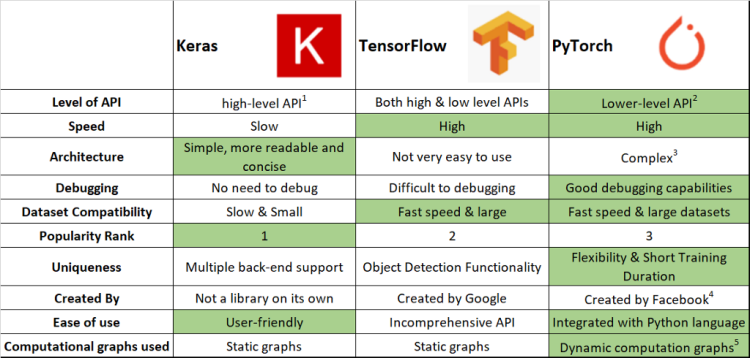

특히 computational graph 부분에서 PyTorch는 dynamic 하게 짤 수 있다는 점에서 크게 편해진다. 

신경망 모델을 설계하는 부분이 static하느냐 dynamic하느냐의 차이. 

- Tensorflow: Define and run. Static. Production에서 많이 사용
- PyToroch: 학계에서 많이 사용. (점점 증가 추세)

PyTorch는 
- numpy 구조를 가지는 tensor 객체로 array 표현
- 자동미분 Autograd를 지원하여 딥러닝 연산을 지원
- 다양한 형태의 딥러닝을 지원하는 함수와 모델을 지원함. 

수업의 튜토리얼 내용을 함께 추가했다. 

In [1]:
import torch
import numpy as np
import pandas as pd

## Tensors

### Tensor initialization

In [28]:
arr_m = np.arange(12).reshape(3, 4)
arr_m

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [29]:
x_np = torch.from_numpy(arr_m) # dtype도 그대로 가져온다. 이 때, int면 나중에 문제가 생긴다. 
x_np

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]], dtype=torch.int32)

In [30]:
x_ones = torch.ones_like(x_np) # retaining the properties of x_np
x_rand = torch.rand_like(x_np, dtype=torch.float) # overriding the datatype

### Tensor attributes

In [31]:
x_np.shape

torch.Size([3, 4])

In [32]:
x_np.dtype

torch.int32

In [33]:
x_np.device

device(type='cpu')

### Tensor Operations

You can move tensor to the GPU if available (CPU --> GPU)

CUDA 11 is required for RTX 3070

tensor는 numpy-like operations 들이 가능하다. 

In [34]:
torch.cuda.is_available()

True

In [35]:
if torch.cuda.is_available():
    x_np = x_np.to('cuda')

In [36]:
x_np.device

device(type='cuda', index=0)

In [37]:
x_np[:, 1] # numpy-like slicing

tensor([1, 5, 9], device='cuda:0', dtype=torch.int32)

In [38]:
x_twos = torch.ones_like(x_np) * 2

torch.cat([x_np, x_twos]) # concatenation

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [ 2,  2,  2,  2],
        [ 2,  2,  2,  2],
        [ 2,  2,  2,  2]], device='cuda:0', dtype=torch.int32)

In [39]:
x_np.mul(x_twos) # element-wise

tensor([[ 0,  2,  4,  6],
        [ 8, 10, 12, 14],
        [16, 18, 20, 22]], device='cuda:0', dtype=torch.int32)

In [40]:
x_np * x_twos # also element-wise

tensor([[ 0,  2,  4,  6],
        [ 8, 10, 12, 14],
        [16, 18, 20, 22]], device='cuda:0', dtype=torch.int32)

In [42]:
x_np.matmul(x_twos.T) 

RuntimeError: "addmm_cuda" not implemented for 'Int'

위의 에러처럼 현재로썬 int가 `matmul`이 안된다. `torch.int`도 안된다. 그냥 int가 안되는 듯. 

`.to()`로 dtype 바꿔주자. 

In [45]:
x_np = x_np.to(torch.float)
x_twos = x_twos.to(torch.float)

In [46]:
x_np.matmul(x_twos.T)

tensor([[12., 12., 12.],
        [44., 44., 44.],
        [76., 76., 76.]], device='cuda:0')

In [47]:
x_np @ x_twos.T

tensor([[12., 12., 12.],
        [44., 44., 44.],
        [76., 76., 76.]], device='cuda:0')

### Bridge with NumPy

Tensors on the CPU and NumPy arrays can share their underlying memory locations, and changing one will change the other.

#### Tensor --> NumPy

In [49]:
t = torch.ones(5)
t

tensor([1., 1., 1., 1., 1.])

In [50]:
t.dtype # 기본이 float32

torch.float32

In [52]:
n = t.numpy()
n

array([1., 1., 1., 1., 1.], dtype=float32)

In [53]:
n.dtype # type을 그대로 받아옴. 

dtype('float32')

#### NumPy --> Tensor

In [54]:
n = np.ones(5)

n.dtype # 기본이 float64

dtype('float64')

In [56]:
t = torch.from_numpy(n)

t.dtype # 마찬가지로 type을 받아온다. 

torch.float64

## A Gentle Introduction to `torch.autograd`

baack propagation에서 쓰인다. 3b1b의 딥러닝 유튜브 동영상이 링크되어있다. 

### Usage in PyTorch 

1 step만 해보자. 

`torchvision`에 있는 pre-trained `resnet18`라는 weight를 써서 한다고 한다. 

In [57]:
import torch, torchvision

In [58]:
model = torchvision.models.resnet18(pretrained=True)
data = torch.rand(1, 3, 64, 64)
labels = torch.rand(1, 1000)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\chlje/.cache\torch\hub\checkpoints\resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Keras style summary를 확인해보자. 

https://anaconda.org/conda-forge/pytorch-model-summary

In [77]:
import pytorch_model_summary as pms

In [80]:
print(pms.summary(model, data))

----------------------------------------------------------------------------
           Layer (type)        Output Shape         Param #     Tr. Param #
               Conv2d-1     [1, 64, 32, 32]           9,408           9,408
          BatchNorm2d-2     [1, 64, 32, 32]             128             128
                 ReLU-3     [1, 64, 32, 32]               0               0
            MaxPool2d-4     [1, 64, 16, 16]               0               0
           BasicBlock-5     [1, 64, 16, 16]          73,984          73,984
           BasicBlock-6     [1, 64, 16, 16]          73,984          73,984
           BasicBlock-7      [1, 128, 8, 8]         230,144         230,144
           BasicBlock-8      [1, 128, 8, 8]         295,424         295,424
           BasicBlock-9      [1, 256, 4, 4]         919,040         919,040
          BasicBlock-10      [1, 256, 4, 4]       1,180,672       1,180,672
          BasicBlock-11      [1, 512, 2, 2]       3,673,088       3,673,088
          B

우선 모델에 input data를 넣어 prediction을 얻는다. 이것이 **forward pass** 이다. 

In [63]:
prediction = model(data)

In [66]:
prediction.shape

torch.Size([1, 1000])

In [67]:
loss = (prediction - labels).sum()
loss

tensor(-509.1737, grad_fn=<SumBackward0>)

In [68]:
loss.backward()

In [71]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

In [72]:
optimizer.step() # Initiate gradient descent 